# **Covid19 Analysis**

In [46]:
import pandas as pd
import numpy as np
from graphic_cov import visualize_covid_cases
import matplotlib.pyplot as plt
import folium
import plotly.express as px
from datetime import datetime, timedelta, date

In [2]:
# Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

In [3]:
# new dataset 
df_covid19 = df_covid19.drop(["People_Tested","People_Hospitalized","UID","ISO3","Mortality_Rate"],axis =1)
df_covid19.head(2)

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate
0,Australia,2020-05-18 11:32:19,-25.0000,133.0000,7060.0,99.0,6394.0,567.0,27.730099
1,Austria,2020-05-18 11:32:19,47.5162,14.5501,16269.0,629.0,14614.0,1026.0,180.638213


In [4]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_table = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]

In [5]:
my_dict_pycountry = {
    'US': 'USA', 
    'Korea, South': 'South Korea', 
    'Taiwan*': 'Taiwan',
    'Congo (Kinshasa)': 'Democratic Republic of the Congo',
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Reun:ion": "Réunion",
    "Congo (Brazzaville)": "Republic of the Congo",
    'Bahamas, The': 'Bahamas',
    'Gambia, The': 'Gambia'
     }
for key, value in my_dict_pycountry.items():
    for df_name in [df_confirmed, df_deaths, df_covid19, df_table]:
        df_name.loc[df_name['country'] == key, "country"] = value

In [6]:
import pycountry_convert as pc
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])
# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

#Collecting Continent Information
df_confirmed.insert(2,"continent", [continents[country_to_continent_code(country)] for country in countries[:]])
df_deaths.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]])
df_covid19.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in countries1[:]])
df_table.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in df_table["country"].values])

In [7]:
### remove Data from other continment
df_table = df_table[df_table["continent"] != "Others"]

In [8]:
df_deaths[df_deaths["continent" ]== 'Others']

,state,country,continent,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20
88,NaN,Diamond Princess,Others,0.000000,0.000000,0,0,0,0,0,...,13,13,13,13,13,13,13,13,13,13
127,NaN,Holy See,Others,41.902900,12.453400,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,NaN,Timor-Leste,Others,-8.874217,125.727539,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
240,NaN,West Bank and Gaza,Others,31.952200,35.233200,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
246,NaN,Kosovo,Others,42.602636,20.902977,0,0,0,0,0,...,27,28,28,28,29,29,29,29,29,29
247,NaN,Burma,Others,21.916200,95.956000,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
251,NaN,MS Zaandam,Others,0.000000,0.000000,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
260,NaN,Western Sahara,Others,24.215500,-12.885800,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)

In [10]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update'],axis =1)
df_countries_cases.index = df_countries_cases["country"]
df_countries_cases = df_countries_cases.drop(['country'],axis=1)

df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update'],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

df_countries_cases.fillna(0,inplace=True)
df_continents_cases.fillna(0,inplace=True)

In [11]:
df_t = pd.DataFrame(pd.to_numeric(df_countries_cases.sum()),dtype=np.float64).transpose()
df_t["Mortality Rate (per 100)"] = np.round(100*df_t["Deaths"]/df_t["Confirmed"],2)
df_t.style.background_gradient(cmap='Wistia',axis=1).format("{:.0f}",subset=["Confirmed"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
0,4731987,315496.000000,1740096.000000,2676395.000000,19776.585084,6.670000


In [16]:
df_continents_cases["Mortality Rate (per 100)"] = np.round(100*df_continents_cases["Deaths"]/df_continents_cases["Confirmed"],2)
df_continents_cases.sort_values('Deaths', ascending= False).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Pastel1_r',subset=["Incident_Rate"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
continent,,,,,,
Europe,1745259.000000,162882.000000,725266.000000,857111.000000,10959.980215,9.330000
North America,1646351.000000,101711.000000,359559.000000,1185081.000000,1335.558903,6.180000
Asia,804245.000000,24840.000000,459739.000000,319666.000000,4171.695243,3.090000
South America,440234.000000,23124.000000,153261.000000,263849.000000,944.482822,5.250000
Africa,85027.000000,2767.000000,32615.000000,49645.000000,757.253770,3.250000
Australia,8585.000000,120.000000,7850.000000,615.000000,60.912632,1.400000
Others,2286.000000,52.000000,1806.000000,428.000000,1546.701499,2.270000


In [13]:
# df_countries_cases.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Wistia')
df_countries_cases["Mortality Rate (per 100)"] = np.round(100*df_countries_cases["Deaths"]/df_countries_cases["Confirmed"],2)
df_countries_cases.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Pastel1_r',subset=["Incident_Rate"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
country,,,,,,
USA,1486742.000000,89564.000000,272265.000000,1124913.000000,451.257709,6.020000
Russia,290678.000000,2722.000000,70209.000000,217747.000000,199.183935,0.940000
United Kingdom,244995.000000,34716.000000,1058.000000,209221.000000,360.891768,14.170000
Brazil,241080.000000,16122.000000,94122.000000,130836.000000,113.417703,6.690000
Spain,230698.000000,27563.000000,146446.000000,56689.000000,493.421176,11.950000
Italy,225435.000000,31908.000000,125176.000000,68351.000000,372.855085,14.150000
France,179693.000000,28111.000000,61327.000000,90255.000000,275.292373,15.640000
Germany,176551.000000,7975.000000,155041.000000,13535.000000,210.721756,4.520000
Turkey,149435.000000,4140.000000,109962.000000,35333.000000,177.183606,2.770000


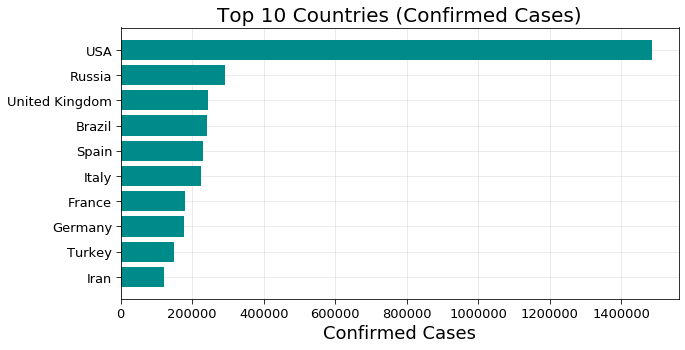

In [20]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Confirmed')["Confirmed"].index[-10:],df_countries_cases.sort_values('Confirmed')["Confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 Countries (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
#plt.savefig(out+'Top 10 Countries (Confirmed Cases).png')

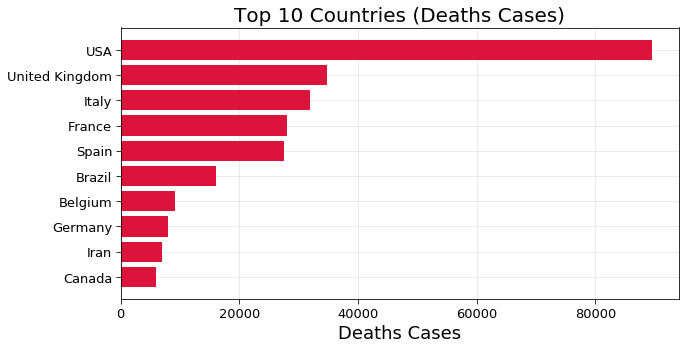

In [22]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Deaths')["Deaths"].index[-10:],df_countries_cases.sort_values('Deaths')["Deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths Cases",fontsize=18)
plt.title("Top 10 Countries (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
#plt.savefig(out+'Top 10 Countries (Deaths Cases).png')

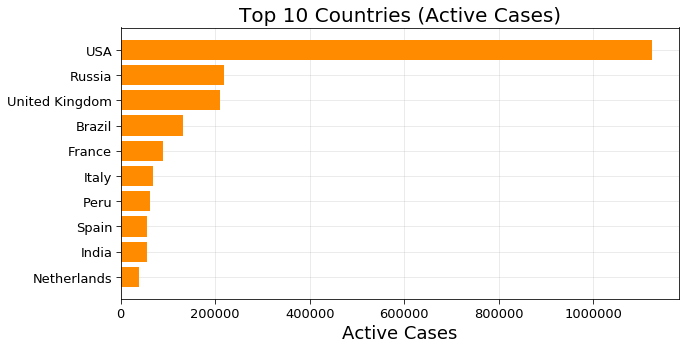

In [24]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Active')["Active"].index[-10:],df_countries_cases.sort_values('Active')["Active"].values[-10:],color="darkorange")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Active Cases",fontsize=18)
plt.title("Top 10 Countries (Active Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
#plt.savefig(out+'Top 10 Countries (Active Cases).png')

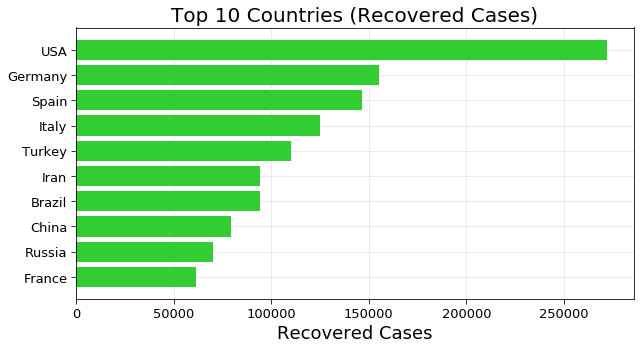

In [25]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Recovered')["Recovered"].index[-10:],df_countries_cases.sort_values('Recovered')["Recovered"].values[-10:],color="limegreen")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Recovered Cases",fontsize=18)
plt.title("Top 10 Countries (Recovered Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
#plt.savefig(out+'Top 10 Countries (Recovered Cases).png')

In [26]:
df_countries_cases.iloc[:,:].corr().style.background_gradient(cmap='Reds')

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
Confirmed,1.000000,0.933245,0.839887,0.979892,0.183750,0.137532
Deaths,0.933245,1.000000,0.806828,0.894279,0.207200,0.270685
Recovered,0.839887,0.806828,1.000000,0.716217,0.197431,0.175884
Active,0.979892,0.894279,0.716217,1.000000,0.161416,0.100055
Incident_Rate,0.183750,0.207200,0.197431,0.161416,1.000000,0.065636
Mortality Rate (per 100),0.137532,0.270685,0.175884,0.100055,0.065636,1.000000


In [27]:
df_continents_cases.iloc[:,:].corr().style.background_gradient(cmap='Reds')

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
Confirmed,1.000000,0.944012,0.897299,0.961440,0.684210,0.870368
Deaths,0.944012,1.000000,0.873822,0.876865,0.802655,0.938288
Recovered,0.897299,0.873822,1.000000,0.742870,0.885520,0.813400
Active,0.961440,0.876865,0.742870,1.000000,0.474585,0.801624
Incident_Rate,0.684210,0.802655,0.885520,0.474585,1.000000,0.759550
Mortality Rate (per 100),0.870368,0.938288,0.813400,0.801624,0.759550,1.000000


In [31]:
world_map = folium.Map(location=[10,0], tiles="cartodbpositron", zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['country']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['state']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "<li>Deaths:   "+str(df_deaths.iloc[i,-1])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df_deaths.iloc[i,-1]/(df_confirmed.iloc[i,-1]+1.00001)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(world_map)

world_map


In [34]:
temp_df = pd.DataFrame(df_countries_cases['Confirmed'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df.iloc[:,-1]), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["Confirmed"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Confirmed Cases Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Confirmed Cases(Log Scale)",colorscale="Reds")
# fig.to_image("Global Heat Map confirmed.png")
fig.show()

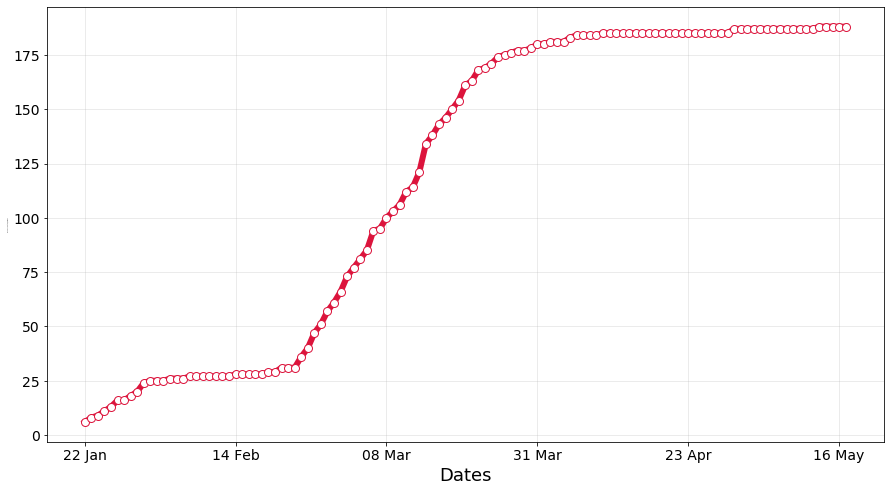

In [39]:

case_nums_country = df_confirmed.groupby("country").sum().drop(['Lat','Long'],axis =1).apply(lambda x: x[x > 0].count(), axis =0)
d = [datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in case_nums_country.index]

f = plt.figure(figsize=(15,8))
f.add_subplot(111)
marker_style = dict(c="crimson",linewidth=6, linestyle='-', marker='o',markersize=8, markerfacecolor='#ffffff')
plt.plot(d, case_nums_country,**marker_style)
plt.tick_params(labelsize = 14)
plt.xticks(list(np.arange(0,len(d),int(len(d)/5))),d[:-1:int(len(d)/5)]+[d[-1]])

#labels
plt.xlabel("Dates",fontsize=18)
plt.ylabel("Number of Countries/Regions",fontsize=1)
plt.grid(alpha = 0.3)

#plt.savefig(out+'spread.png')
plt.show()
plt.close()

In [47]:
cols = 1
rows = 1
f = plt.figure(figsize=(10,10*rows))
visualize_covid_cases(df_confirmed, df_deaths,continent = "All",figure = [f,rows,cols, 1])

plt.savefig(out+'COIVD-19-World.png')
plt.show()

NameError: name 'np' is not defined